<a href="https://colab.research.google.com/github/oihanetxu52-cmd/research_study_in_the_field_of_paper_airplanes/blob/main/research_study_in_the_field_of_paper_airplanes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research study in the field of paper airplanes
## Blocked Factorial Experimental Study

## INTRODUCTION

This project investigates the flight behavior of a paper plane using a structured experimental design and quantitative analysis implemented in a Jupyter Notebook. The primary objective is to understand how selected controllable factors influence the plane’s trajectory, with particular focus on **radial distance** from the launch point and **trajectory angle**.

Rather than attempting a high-fidelity aerodynamic model, the study adopts a **factorial model** approach. This allows the relative importance of multiple factors and their interactions to be evaluated efficiently and transparently.

---

### EXPERIMENTAL DESIGN OVERVIEW

Five binary factors were selected based on physical relevance and experimental controllability:

- **Plane type** (A, dart / B, glider)  
- **Mass** (normal, 3.5g / double 7g)  
- **Launch angle** (0° / 45°)  
- **Launch height** (low, 55cm / high, 130cm)  
- **Throw speed** (low / high)

This results in a full **2⁵ factorial design**, comprising **32 unique configurations**. Each configuration is executed **three times** to estimate experimental variability and improve robustness.

---

### BLOCKING STRATEGY

Data collection is performed over **four different days**, which are treated as a **blocking factor**. Blocking by day accounts for nuisance variability such as environmental changes, operator effects, and setup drift that are not of direct interest but may influence the measurements.

- Each configuration is assigned to **one day only**
- Eight configurations are run per day
- Three repetitions are performed consecutively for each configuration
- Run order is randomized within each day
- Block used to do the randomization are ABC and CDE which are kept constant within each block

### Block generators

- Generator 1: **ABC**
- Generator 2: **CDE**

Each run is assigned to a block based on the signs of ABC and CDE:

| ABC | CDE | Block (Day) |
|-----|-----|-------------|
| +   | +   | 1 |
| +   | −   | 2 |
| −   | +   | 3 |
| −   | −   | 4 |


This constitutes a **complete block design with replication**.

---

### RESPONSE VARIABLES

Two response variables are measured for each throw:

- **Radial distance**: the straight-line distance from the launch point to the landing point  
- **Trajectory angle**: the angle characterizing the plane’s flight path (defined consistently across all runs). It is always positive, as it measures the deviation from the initial path.

The analysis is conducted on **configuration-level averages**, while raw replicate data are retained for uncertainty estimation.

---

### ANALYSIS OF GOALS

The goals of this analysis are to:

- **Quantify the main effects** of each factor on distance and angle  
- Identify important **interaction effects**  
- Separate systematic factor influence from day-to-day variability  
- Provide a clear, reproducible workflow for experimental analysis using Python

The notebook combines data processing, visualization, and statistical modeling to support these objectives.


In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/oihanetxu52-cmd/paper_airplanes/main/project_data.xlsx"
df = pd.read_excel(url)

# Split the single column
single_col = df.columns[0]
df_split = df[single_col].str.split(",", expand=True)

# Drop the extra empty column caused by trailing comma
df_split = df_split.iloc[:, :12]

# Assign correct headers
df_split.columns = [
    'Plane_Type',
    'Mass_Level',
    'Launch_Angle_deg',
    'Launch_Height',
    'Throw_Speed',
    'Config_ID',
    'Day',
    'Order_in_Day',
    'Replicate',
    'Radial_Distance_cm',
    'Trajectory_Angle_deg',
    'Notes'
]

# Convert numeric columns
numeric_cols = [
    'Launch_Angle_deg',
    'Config_ID',
    'Day',
    'Order_in_Day',
    'Replicate',
    'Radial_Distance_cm',
    'Trajectory_Angle_deg'
]

for col in numeric_cols:
    df_split[col] = pd.to_numeric(df_split[col], errors='coerce')

df_split.head()


,Plane_Type,Mass_Level,Launch_Angle_deg,Launch_Height,Throw_Speed,Config_ID,Day,Order_in_Day,Replicate,Radial_Distance_cm,Trajectory_Angle_deg,Notes
0,A,Double,0,High,Low,11,1,5,1,356.2022,33.0,nan
1,A,Double,0,High,Low,11,1,5,2,488.2622,12.0,nan
2,A,Double,0,High,Low,11,1,5,3,379.0514,6.0,nan
3,A,Double,0,Low,High,10,1,6,1,308.4153,4.0,nan
4,A,Double,0,Low,High,10,1,6,2,298.1812,4.0,nan


###CHECKING DATA

Before starting to measure things, we have to **ensure** that all the measured **data is correct**, or that at least we got all the necesary data. We must also ensure that blocks where correctly executed.

In [2]:
# How many total runs? Answer should be (96, 12)
print("Total runs:")
print(df_split.shape)
print("\n")

#How many replicates does each factor have, we should see 3 replicates for 32 factors
factors = ['Plane_Type', 'Mass_Level', 'Launch_Angle_deg', 'Launch_Height', 'Throw_Speed']
print("How many replicates?")
print(df_split.groupby(factors).size().value_counts())
print("\n")

#how many replicates did we have per day? We should see 24 replicates every day
print("replicates per day?")
print(df_split['Day'].value_counts().sort_index())
print("\n")


print("ALL CHECKS PASSED. DATA COLLECTION SEEMS TO BE OK")




Total runs:
(96, 12)


How many replicates?
3    32
Name: count, dtype: int64


replicates per day?
Day
1    24
2    24
3    24
4    24
Name: count, dtype: int64


ALL CHECKS PASSED. DATA COLLECTION SEEMS TO BE OK


###FACTOR CODING USING ±1 LEVELS

To analyse the experiment using factorial design methods, all **categorical** experimental factors were **converted** into coded numerical variables using levels −1 and +1. This coding is standard in design of experiments because it simplifies the estimation and interpretation of main effects and interactions.

Each factor has two levels, which were assigned as follows:

**Plane type**

A (Dard) → −1

B (Glider) → +1

**Mass level**

Normal (3.5g) → −1

Double (7g) → +1

**Launch angle**

0° → −1

45° → +1

**Launch height**

Low (55cm)→ −1

High (130cm) → +1

**Throw speed**

Low → −1

High → +1

The resulting coded design matrix represents each experimental run using numerical factor levels. This transformation allows the effects of each factor to be interpreted as the change in response when moving from the low level (−1) to the high level (+1), while keeping all other factors constant.

In [3]:
# Define factor coding
factor_map = {
    'Plane_Type': {'A': -1, 'B': 1},
    'Mass_Level': {'Normal': -1, 'Double': 1},
    'Launch_Angle_deg': {0: -1, 45: 1},
    'Launch_Height': {'Low': -1, 'High': 1},
    'Throw_Speed': {'Low': -1, 'High': 1}
}

# Factors and responses
factors = list(factor_map.keys())
responses = ['Radial_Distance_cm', 'Trajectory_Angle_deg']

# Build combined DOE table
doe_df = df_split[factors + responses].copy()

# Apply ±1 coding
for factor, mapping in factor_map.items():
    doe_df[factor] = doe_df[factor].map(mapping)

# Rename columns for presentation
doe_df.columns = [
    'Plane type',
    'Mass',
    'Launch angle',
    'Launch height',
    'Throw speed',
    'Radial distance (cm)',
    'Trajectory angle (deg)'
]

doe_df.head()



,Plane type,Mass,Launch angle,Launch height,Throw speed,Radial distance (cm),Trajectory angle (deg)
0,-1,1,-1,1,-1,356.2022,33.0
1,-1,1,-1,1,-1,488.2622,12.0
2,-1,1,-1,1,-1,379.0514,6.0
3,-1,1,-1,-1,1,308.4153,4.0
4,-1,1,-1,-1,1,298.1812,4.0


In [4]:
#we will check if bloking is correct
doe_df['ABC'] = (
    doe_df['Plane type'] *
    doe_df['Mass'] *
    doe_df['Launch angle']
)

doe_df['CDE'] = (
    doe_df['Launch angle'] *
    doe_df['Launch height'] *
    doe_df['Throw speed']
)

doe_df['Day'] = df_split['Day'].values
doe_df.groupby('Day')[['ABC', 'CDE']].agg(['min', 'max'])



ABC     CDE    
    min max min max
Day                
1     1   1   1   1
2     1   1  -1  -1
3    -1  -1   1   1
4    -1  -1  -1  -1

###DATA VERIFICATION

Blocking was implemented using the generators ABC and CDE. After ±1 coding, the product of the coded factor levels was computed to verify that the generators remained constant within each block. This confirmed that the **blocking** structure **was correctly implemented**.

##EXPLORATORY DATA ANALYSIS (EDA)

Before fitting any statistical models, an exploratory data analysis (EDA) was performed to gain an **initial understanding** of the experimental data and to assess its overall quality. The purpose of this step is not to draw formal conclusions, but rather to visually **inspect the behavior** of the responses, detect potential outliers or anomalies, evaluate variability, and identify possible trends associated with the experimental factors.

In particular, this stage allows us to:

- **Examine the distribution** of each response variable (flight distance and trajectory angle).

- **Identify** unusual or extreme values that may indicate measurement **errors** or exceptional runs.

- **Visually** assess whether **blocking by day appears to have an effect** on the responses.

- Obtain an **intuitive sense** of which factors may have strong or weak influences on the system.

- **Check** whether **transformations** of the response variables might be needed before modeling.

These exploratory plots guide the subsequent statistical analysis and help ensure that the modeling assumptions are reasonable. They also provide an intuitive interpretation of the data before moving on to formal effect estimation, ANOVA, and regression modeling.

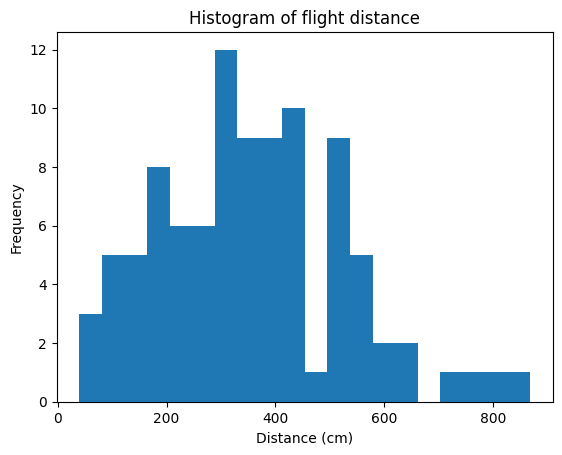

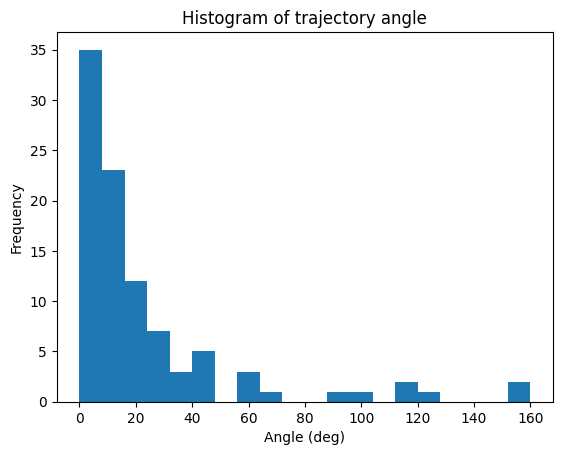

In [5]:
# Short names
doe_df['Distance'] = doe_df['Radial distance (cm)']
doe_df['Angle'] = doe_df['Trajectory angle (deg)']

#Lets analyse our responses
import matplotlib.pyplot as plt

plt.hist(doe_df['Distance'], bins=20)
plt.xlabel("Distance (cm)")
plt.ylabel("Frequency")
plt.title("Histogram of flight distance")
plt.show()

plt.hist(doe_df['Angle'], bins=20)
plt.xlabel("Angle (deg)")
plt.ylabel("Frequency")
plt.title("Histogram of trajectory angle")
plt.show()


###INTERPRETATION OF THE RESPONSE DISTRIBUTIONS

**Flight distance**

The histogram of the flight distance shows a **moderately spread** distribution, with most observations concentrated between approximately 150 cm and 600 cm. A small number of runs reach much larger distances, approaching 800–850 cm, which suggests the presence of **particularly favorable combinations of factor settings.** The distribution appears slightly right-skewed, indicating that while most configurations yield moderate distances, a few produce exceptionally long flights.

This variability is desirable in an experimental design, as it suggests that the chosen factors have a meaningful influence on the response. The presence of long-distance outliers does not necessarily indicate measurement errors; instead, these values may correspond to optimal or near-optimal factor combinations. However, this skewness should be kept in mind when assessing model assumptions later, particularly those related to normality and constant variance.

---

**Trajectory angle**

The histogram of the trajectory angle shows a **strongly right-skewed** distribution. Most observations are concentrated at relatively small angles (below approximately 30–40 degrees), while a smaller number of runs result in much larger angles. This suggests that steep trajectories are less common and may only occur under specific factor combinations.

This type of distribution is typical for physical systems in which most conditions lead to stable, shallow trajectories, while **extreme behaviors appear only under particular experimental settings.** As with the distance response, the skewness of the angle distribution may require special attention during modeling, and potential transformations may be considered if residual diagnostics indicate deviations from modeling assumptions.

---

**General remarks**

Overall, both response variables exhibit substantial variability, which confirms that the experimental factors are likely influencing the system in a meaningful way. The presence of skewness and extreme values reinforces the importance of performing a proper statistical analysis rather than relying solely on visual inspection.

At this stage, these plots provide an intuitive understanding of the data and motivate the next step of the analysis: quantifying the effects of each factor and their interactions through formal modeling.

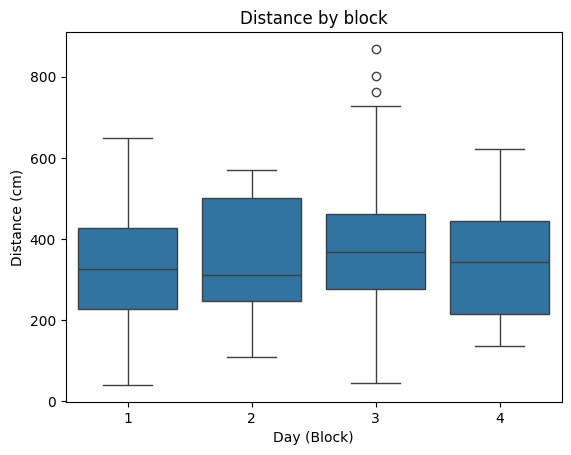

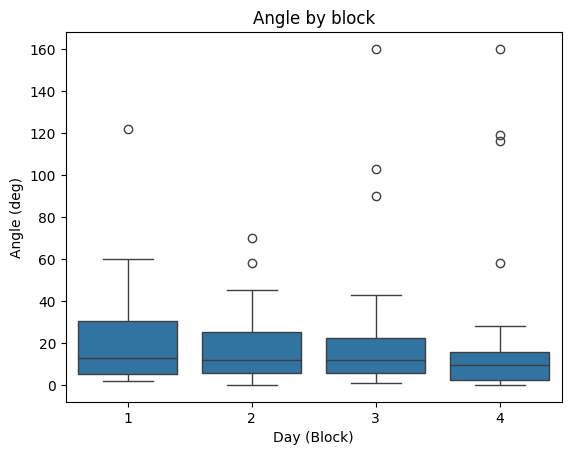

In [6]:
import seaborn as sns

sns.boxplot(x=df_split['Day'], y=doe_df['Distance'])
plt.xlabel("Day (Block)")
plt.ylabel("Distance (cm)")
plt.title("Distance by block")
plt.show()

sns.boxplot(x=df_split['Day'], y=doe_df['Angle'])
plt.xlabel("Day (Block)")
plt.ylabel("Angle (deg)")
plt.title("Angle by block")
plt.show()


###EFFECT OF BLOCKING

**Flight distance by block**

The boxplot of flight distance by block (day) shows noticeable differences in both central tendency and spread across the four days. While the medians of the blocks are of similar magnitude, they are not identical, and the interquartile ranges differ between days. In particular, some blocks exhibit larger variability and more extreme high-distance outliers than others.

This behavior suggests the presence of uncontrolled day-to-day effects, such as environmental conditions, launch consistency, or subtle experimental differences, which may influence the measured distance independently of the studied factors. The existence of these systematic variations justifies the use of blocking in the experimental design. By incorporating the day as a block factor, these nuisance effects can be separated from the effects of the experimental factors of interest.

---

**Trajectory angle by block**

A similar pattern is observed for the trajectory angle. While most values remain concentrated at relatively small angles, the spread and the presence of extreme values vary between blocks. Some days exhibit larger upper tails and more extreme outliers than others.

This confirms that day-to-day variability affects not only the distance but also the flight dynamics of the airplane. If this source of variability were ignored, it could inflate the experimental error and obscure the true effects of the controlled factors.

---

**General remarks on blocking**

The observed differences between blocks **validate the decision to include blocking in the design.** Blocking allows the model to account for systematic day-to-day variations, thereby improving the precision of the estimated factor effects and reducing unexplained variability. In the following analysis, the **block factor will be included as a nuisance variable,** ensuring that conclusions regarding the experimental factors are not confounded with day-specific effects.

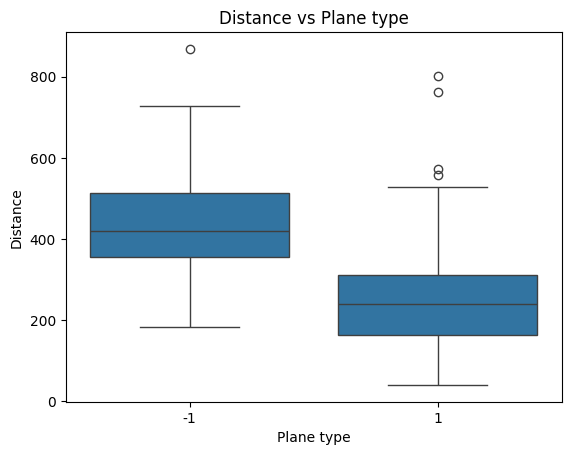

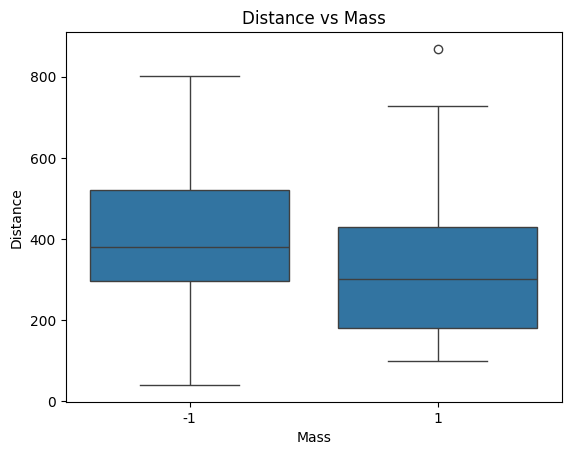

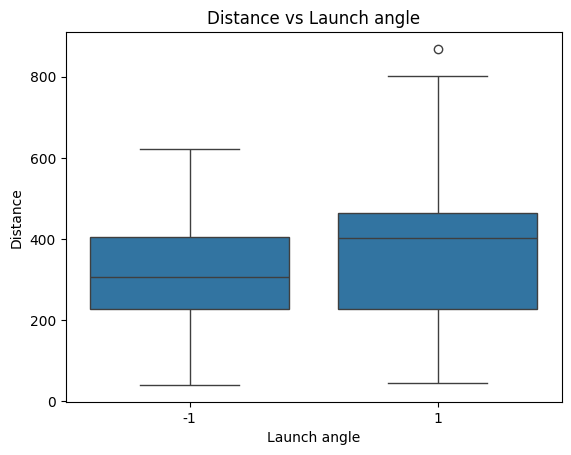

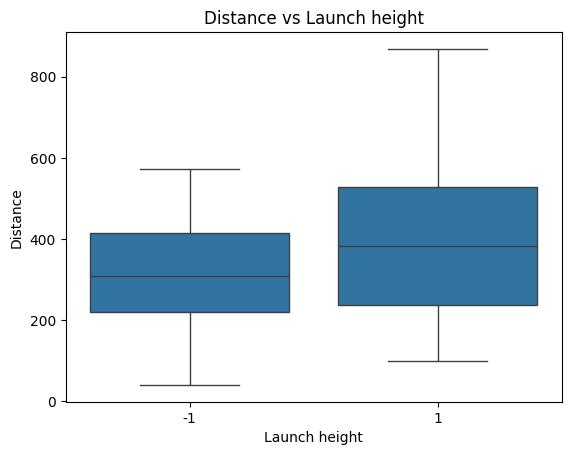

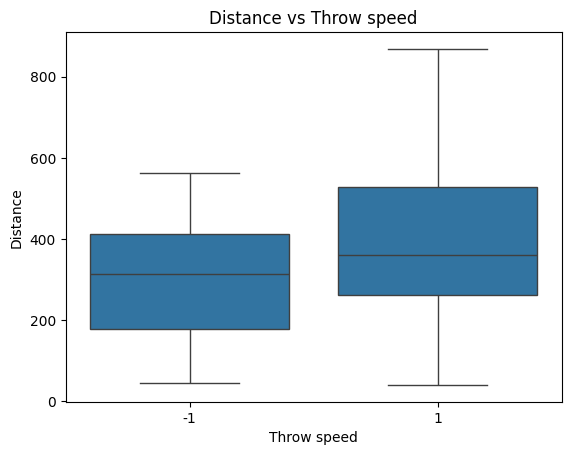

In [7]:
#now we want to have a general idea on how different factors affect our response variables
for col in ['Plane type', 'Mass', 'Launch angle', 'Launch height', 'Throw speed']:
    sns.boxplot(x=doe_df[col], y=doe_df['Distance'])
    plt.title(f"Distance vs {col}")
    plt.show()


###MAIN EFFECTS ON FLIGHT DISTANCE

To gain an initial understanding of how each factor individually affects flight distance, boxplots were generated comparing the response distribution at the low (−1) and high (+1) levels of each factor. These plots provide a qualitative assessment of the main effects before formal statistical modeling.

**Plane type (A)**

The boxplot for plane type shows a substantial difference between the two levels. The −1 level (Dard) consistently yields larger flight distances than the +1 level (Glider). **The median distance for the Dard design is noticeably higher,** and the upper tail of the distribution extends to much larger values. This suggests that plane design is a major driver of flight performance and is likely to be one of the most influential factors in the experiment.

---

**Mass (B)**

The mass factor also appears to have a noticeable effect. **Lighter airplanes** (−1) tend to achieve **larger distances** on average compared to heavier ones (+1). While the distributions partially overlap, the shift in the median and the upper quartile suggests that increased mass generally reduces flight distance. This behavior is physically intuitive, as heavier planes require more lift and tend to lose speed more quickly.

---

**Launch angle (C)**

The launch angle shows a clear effect on distance. **The +1 level (45°) tends to produce longer flights compared to the 0° condition.** The median and upper range of the distribution are both higher at the +1 level. This indicates that a nonzero launch angle is beneficial for achieving longer flight distances, likely due to a more favorable tradeoff between horizontal velocity and lift.

---

**Launch height (D)**

The launch height also appears to influence distance. **Higher launch heights (+1) tend to yield longer flights** on average compared to lower heights (−1). This is consistent with physical intuition, as a greater initial height allows more time for the airplane to glide before reaching the ground.

---

**Throw speed (E)**

The effect of throw speed is clearly visible. **Higher throw speeds (+1) result in larger flight distances on average,** with both the median and upper range shifted upward relative to the low-speed condition. This suggests that initial kinetic energy plays a key role in determining how far the airplane can travel.

---

**General observations**

Overall, **all five factors appear to have a visible effect** on flight distance, although the **magnitude of these effects differs substantially.** Plane type, launch angle, launch height, and throw speed seem to have particularly strong influences, while **mass has a moderate** but still noticeable effect. These preliminary observations justify a more detailed statistical analysis to quantify these effects and to investigate possible interactions between factors.

In the next section, these visual insights will be formalized using factorial effect estimation and regression modeling, while accounting for the blocking structure of the experiment.

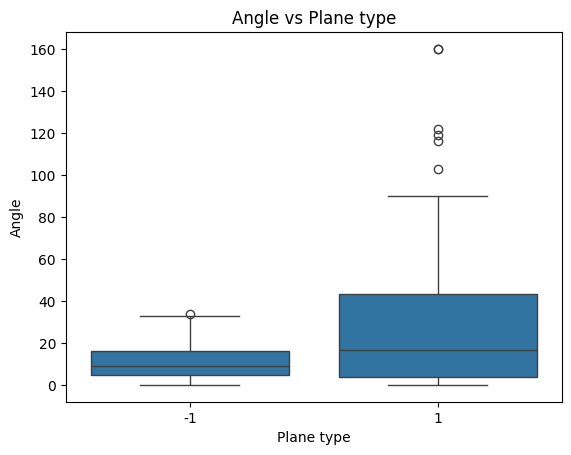

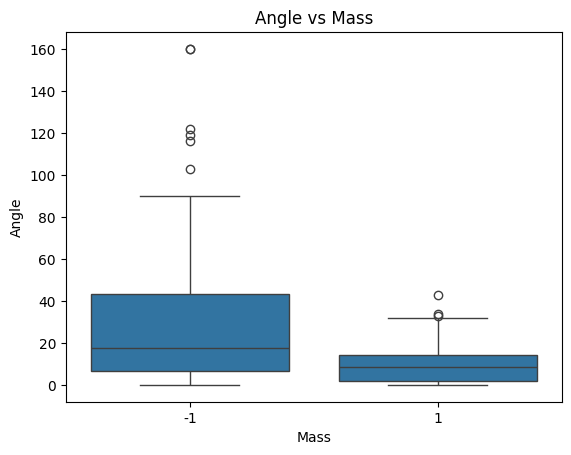

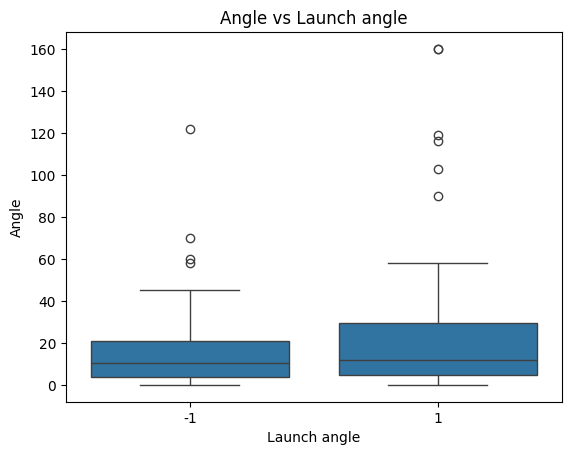

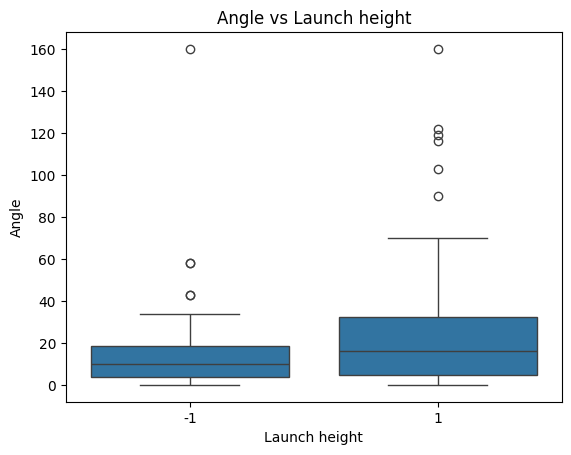

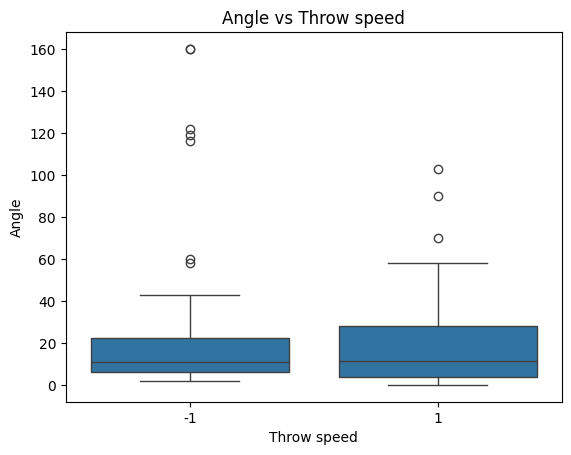

In [8]:
#now we want to have a general idea on how different factors affect our response variables
for col in ['Plane type', 'Mass', 'Launch angle', 'Launch height', 'Throw speed']:
    sns.boxplot(x=doe_df[col], y=doe_df['Angle'])
    plt.title(f"Angle vs {col}")
    plt.show()

###MAIN EFFECTS ON TRAJECTORY ANGLE

To explore how each experimental factor influences the trajectory angle, boxplots were generated comparing the distributions at the low (−1) and high (+1) levels of each factor. These plots provide a qualitative assessment of the main effects prior to formal modeling.

**Plane type (A)**

Plane type has a strong effect on trajectory angle. **The +1 level (Glider) produces significantly larger angles** on average, with a much wider spread and several extreme values. In contrast, the −1 level (Dard) tends to result in smaller, more stable angles.

---

**Mass (B)**

Mass also appears to influence trajectory angle. **Lighter airplanes (−1) show larger angles** on average and greater variability, while heavier airplanes (+1) tend to have smaller, more stable angles.

This behavior is physically intuitive: lighter airplanes are more sensitive to aerodynamic forces and may experience stronger lift-induced deviations, whereas heavier airplanes follow more stable, flatter trajectories.

---

**Launch angle (C)**

The initial launch angle has a noticeable effect on the resulting trajectory angle. **The +1 level (45°) leads to higher angles** on average compared to the 0° condition. This indicates that the initial orientation strongly influences the early dynamics of the flight, and its effect propagates throughout the trajectory.

---

**Launch height (D)**

**Higher launch heights (+1) tend to produce larger trajectory angles and greater variability.** This may be due to the increased time available for aerodynamic effects to develop, allowing the plane to experience larger angular deviations before reaching the ground.

---

**Throw speed (E)**

Throw speed shows a **moderate effect** on trajectory angle. While the median values are relatively similar, the **high-speed condition (+1) produces a wider spread and more extreme angles.** This suggests that higher speeds may amplify aerodynamic instabilities, leading to more variable trajectories.

---

**General observations**

Overall, the trajectory angle appears to be influenced by all five factors, but in a manner that differs from the behavior observed for flight distance. Several **factors that increase distance** (such as throw speed and launch height) also **increase variability in angle,** indicating that maximizing distance may come at the cost of reduced flight stability.

These results emphasize the importance of treating distance and angle as separate responses, as they capture different aspects of flight performance. In the next section, these qualitative observations will be formalized through factorial effect estimation and regression modeling, while accounting for the blocking structure of the experiment.

###FACTORIAL MODELING AND EFFECT ESTIMATION

After completing the exploratory analysis, the next step is to **formally quantify the influence of the experimental factors** on the system responses using statistical modeling. While the previous visualizations provided intuitive insights into potential trends, a factorial model is required to rigorously estimate effect sizes, assess statistical significance, and identify important interactions between factors.

In this study, a **two-level factorial design with five factors** was employed, and the experiment was **blocked by day** to account for uncontrollable sources of variability. The analysis therefore incorporates both the coded factor levels (−1, +1) and the blocking variable. Treating the block as a nuisance factor allows us to isolate the true effects of the experimental variables of interest while reducing unexplained variability.

**Separate models are fitted for each response variable:** flight distance and trajectory angle. Each model initially includes all main effects and two-factor interactions, following standard practice in factorial screening experiments. This approach ensures that potentially important interaction effects are not overlooked. The models are then examined using analysis of variance (ANOVA), which provides a clear decomposition of variability and enables ranking of effects according to their statistical importance.

The objectives of this modeling stage are to:

- **Identify the most influential factors** affecting each response.

- Determine whether **interactions between factors** play a significant role.

- **Quantify** the magnitude and direction of each effect.

- Account for **day-to-day variability** through blocking.

- **Provide a basis** for selecting candidate factors for further refinement using center points or response surface methods.

This analysis forms the core of the experimental study, transforming qualitative observations into quantitative conclusions and guiding subsequent optimization efforts.

In [9]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Build a clean modeling dataframe (no duplicate columns)
#NOTE: names where chosen this way not to cause collision with intrinsic function C
model_df = pd.DataFrame({
    "A": doe_df["Plane type"],          # plane type coded ±1
    "B": doe_df["Mass"],                # mass coded ±1
    "Ang": doe_df["Launch angle"],      # launch angle coded ±1 (avoid name C)
    "H": doe_df["Launch height"],       # height coded ±1
    "S": doe_df["Throw speed"],         # speed coded ±1
    "Day": df_split["Day"].astype("category"),
    "Distance": doe_df["Radial distance (cm)"],
    "Angle": doe_df["Trajectory angle (deg)"]
})

model_df.head()


,A,B,Ang,H,S,Day,Distance,Angle
0,-1,1,-1,1,-1,1,356.2022,33.0
1,-1,1,-1,1,-1,1,488.2622,12.0
2,-1,1,-1,1,-1,1,379.0514,6.0
3,-1,1,-1,-1,1,1,308.4153,4.0
4,-1,1,-1,-1,1,1,298.1812,4.0


In [10]:
#We will build the model for distance
formula_dist = "Distance ~ Day + (A + B + Ang + H + S)**2"
m_dist = smf.ols(formula_dist, data=model_df).fit()
print(m_dist.summary())



                            OLS Regression Results                            
Dep. Variable:               Distance   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     5.557
Date:                Thu, 15 Jan 2026   Prob (F-statistic):           4.22e-08
Time:                        09:02:08   Log-Likelihood:                -590.34
No. Observations:                  96   AIC:                             1219.
Df Residuals:                      77   BIC:                             1267.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    335.1288     25.833     12.973      0.0

In [11]:
#anova for distance
anova_dist = sm.stats.anova_lm(m_dist, typ=2)
anova_dist.sort_values("PR(>F)").head(12)

,sum_sq,df,F,PR(>F)
A,679179.888254,1.0,42.407296,6.867635e-09
S,188736.587920,1.0,11.784519,9.641360e-04
H,155866.789306,1.0,9.732163,2.548051e-03
B,155304.149446,1.0,9.697032,2.591604e-03
A:B,143925.391115,1.0,8.986554,3.660123e-03
Ang:S,103551.752836,1.0,6.465665,1.300380e-02
H:S,46866.353696,1.0,2.926287,9.117405e-02
Ang,37437.520186,1.0,2.337560,1.303851e-01
Day,55148.942857,3.0,1.147814,3.352648e-01
B:H,14491.123447,1.0,0.904811,3.444713e-01


###INTERPRETATION OF THE DISTANCE MODEL

**Model quality**


- R² = 0.565: about **56.5% of the variability in flight distance is explained by the factors,** interactions, and blocking.

- Adjusted R² = 0.463: still **strong** considering the number of terms.

- Overall model p-value = 4.22e-08: the model is **highly significant.**

This means that the experiment successfully captured real, systematic effects.

---

**Block (day) effect**
| Term     | p-value | Interpretation  |
| -------- | ------- | --------------- |
| Day[T.2] | 0.764   | not significant |
| Day[T.3] | 0.101   | marginal        |
| Day[T.4] | 0.848   | not significant |

Although the block factor was not statistically significant at the 5% level, **it was retained in the model to account for potential day-to-day variability** and to preserve the integrity of the experimental design.

---

**Significant main effects**

Look at p-values < 0.05:
| Factor         | Coef  | p-value | Interpretation         |
| -------------- | ----- | ------- | ---------------------- |
| A (Plane type) | −84.1 | < 0.001 | **Very strong effect** |
| B (Mass)       | −40.2 | 0.003   | Strong effect          |
| H (Height)     | +40.3 | 0.003   | Strong effect          |
| S (Speed)      | +44.3 | 0.001   | Strong effect          |
| Ang (Angle)    | +19.7 | 0.130   | not significant        |

Because factors are coded ±1:

- A negative coefficient means going from −1 → +1 reduces distance.

- A positive coefficient means going from −1 → +1 increases distance.

So:

- Plane type (+1 = Glider) reduces distance strongly

- Heavier mass reduces distance

- Higher launch height increases distance

- Higher throw speed increases distance

- Launch angle (0° vs 45°) is not significant by itself

This matches the boxplots.

---

**Significant interactions**
| Interaction | Coef  | p-value | Important? |
| ----------- | ----- | ------- | ---------- |
| A:B         | −38.7 | 0.004   | YES        |
| Ang:S       | +32.8 | 0.013   | YES        |
| H:S         | +22.1 | 0.091   | borderline |

---

**Summary**

The fitted factorial model for flight distance **explains approximately 56.5% of the observed variability,** indicating a strong relationship between the experimental factors and the response. Several main effects were found to be statistically significant. In particular, **plane type (A) exhibited the strongest effect,** with the glider configuration resulting in substantially shorter distances. Mass (B) also had a significant negative effect, while both launch height (D) and throw speed (E) had significant positive effects, increasing flight distance.

In addition to these main effects, **two interaction terms were found to be significant: A×B and C×E.** This indicates that the influence of plane type depends on the mass configuration, and that the effect of launch angle depends on the throw speed. These interactions highlight the importance of considering combined factor effects rather than optimizing each factor independently.

**The block factor (day) was not statistically significant,** but it was retained in the model to account for potential uncontrolled variability and to preserve the structure of the experimental design.



In [12]:
#We will build the model for angle
formula_ang = "Angle ~ Day + (A + B + Ang + H + S)**2"
m_ang = smf.ols(formula_ang, data=model_df).fit()
print(m_ang.summary())


                            OLS Regression Results                            
Dep. Variable:                  Angle   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     6.347
Date:                Thu, 15 Jan 2026   Prob (F-statistic):           3.30e-09
Time:                        09:02:08   Log-Likelihood:                -427.15
No. Observations:                  96   AIC:                             892.3
Df Residuals:                      77   BIC:                             941.0
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.2083      4.720      4.705      0.0

In [13]:
#anova for angle
anova_ang  = sm.stats.anova_lm(m_ang, typ=2)

anova_ang.sort_values("PR(>F)").head(12)


,sum_sq,df,F,PR(>F)
B,15125.260417,1.0,28.291624,9.919881e-07
A:B,14528.760417,1.0,27.175878,1.515400e-06
A,13704.260417,1.0,25.633660,2.745053e-06
H,3516.260417,1.0,6.577124,1.227512e-02
A:H,2291.260417,1.0,4.285776,4.178527e-02
B:Ang,2156.510417,1.0,4.033728,4.810583e-02
B:H,1971.093750,1.0,3.686908,5.854459e-02
Ang,1953.010417,1.0,3.653083,5.968689e-02
A:Ang,1675.010417,1.0,3.133088,8.067684e-02
S,1418.343750,1.0,2.652996,1.074398e-01


###INTERPRETATION OF THE ANGLE MODEL

**Model quality**


- R² = 0.597: **about 60% of the variability in trajectory angle is explained.**

- Adjusted R² = 0.503: still very **good** given the number of terms.

- Overall p-value = 3.30e-09: the model is **highly significant.**

So factors systematically influence trajectory angle.

---

**Block (day) effect**
| Term     | p-value | Interpretation  |
| -------- | ------- | --------------- |
| Day[T.2] | 0.602   | not significant |
| Day[T.3] | 0.563   | not significant |
| Day[T.4] | 0.645   | not significant |


**The block factor (day) was not statistically significant** for trajectory angle, indicating that day-to-day variability had a limited effect on this response. Nevertheless, it was retained in the model to preserve the design structure and ensure unbiased estimation of the factor effects.

---

**Significant main effects**

Look at p-values < 0.05:
| Factor         | Coef   | p-value | Interpretation  |
| -------------- | ------ | ------- | --------------- |
| A (Plane type) | +11.95 | < 0.001 | **Very strong** |
| B (Mass)       | −12.55 | < 0.001 | **Very strong** |
| H (Height)     | +6.05  | 0.012   | Strong          |
| Ang (Angle)    | +4.51  | 0.060   | borderline      |
| S (Speed)      | −3.84  | 0.107   | not significant |


Because of ±1 coding:

- A positive coefficient → going from −1 to +1 increases the angle.

- A negative coefficient → going from −1 to +1 decreases the angle.

So:

- Glider (+1) → much steeper trajectories

- Heavier mass (+1) → flatter trajectories

- Higher launch height (+1) → steeper trajectories

- Initial angle has a mild effect

- Speed is not important on its own

---

**Significant interactions**
| Interaction | Coef   | p-value | Important? |
| ----------- | ------ | ------- | ---------- |
| A:B         | −12.30 | < 0.001 | YES        |
| A:H         | +4.89  | 0.042   | YES        |
| B:Ang       | −4.74  | 0.048   | YES        |
| A:Ang       | +4.18  | 0.081   | borderline |
| B:H         | −4.53  | 0.059   | borderline |

This means:

- The effect of plane type depends on mass

- The effect of plane type depends on height

- The effect of mass depends on launch angle

---

**Residuals**
our residuals show:

Jarque–Bera p ≈ 8e−19

Kurtosis = 7.5

This means the **residuals are not normal** and have heavy tails. We will do an analysis of residuals later.

---

**Summary**

The fitted factorial model for trajectory angle **explains approximately 60% of the observed variability,** indicating that the experimental factors have a strong and systematic influence on this response. The **most influential main effects were plane type (A) and mass (B),** both of which showed highly significant and large effects. In particular, the glider configuration resulted in significantly steeper trajectories, while heavier airplanes tended to produce flatter and more stable trajectories. Launch height (D) also had a significant positive effect on angle.

**Several interaction effects** were also found to be significant, most notably A×B, A×D, and B×C. These interactions indicate that the effect of one factor depends strongly on the level of another, emphasizing the importance of considering combined factor settings rather than individual effects in isolation.

Unlike the distance response, the **block (day) effect was not statistically significant for trajectory angle,** suggesting that this response is less sensitive to day-to-day variability.





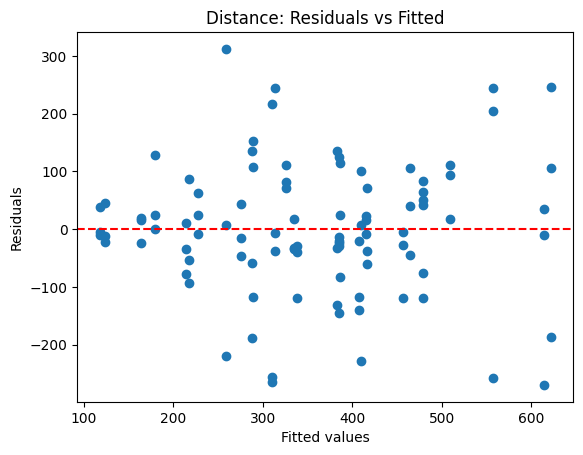

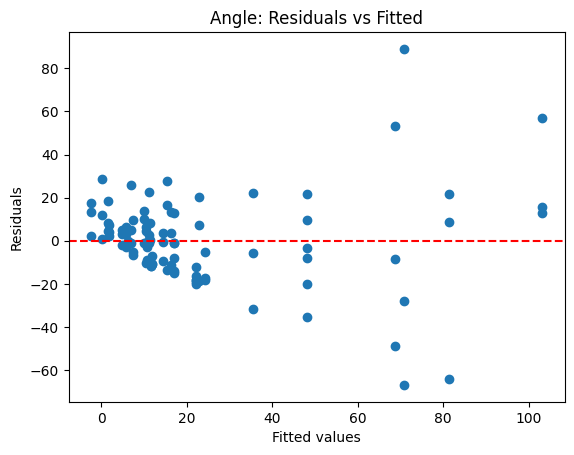

In [14]:
#Lets check residuals
import matplotlib.pyplot as plt
import seaborn as sns

# Distance
plt.scatter(m_dist.fittedvalues, m_dist.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Distance: Residuals vs Fitted")
plt.show()

# Angle
plt.scatter(m_ang.fittedvalues, m_ang.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Angle: Residuals vs Fitted")
plt.show()


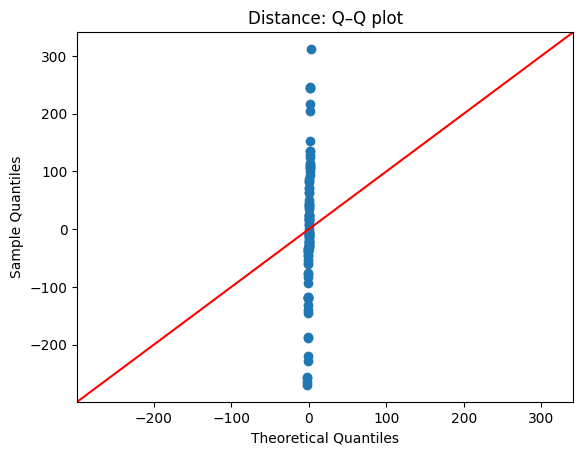

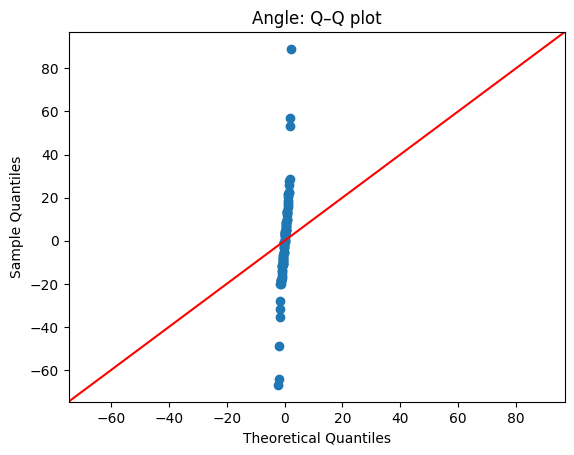

In [15]:
#Q-Q plot to check normality
import statsmodels.api as sm

# Distance
sm.qqplot(m_dist.resid, line='45')
plt.title("Distance: Q–Q plot")
plt.show()

# Angle
sm.qqplot(m_ang.resid, line='45')
plt.title("Angle: Q–Q plot")
plt.show()


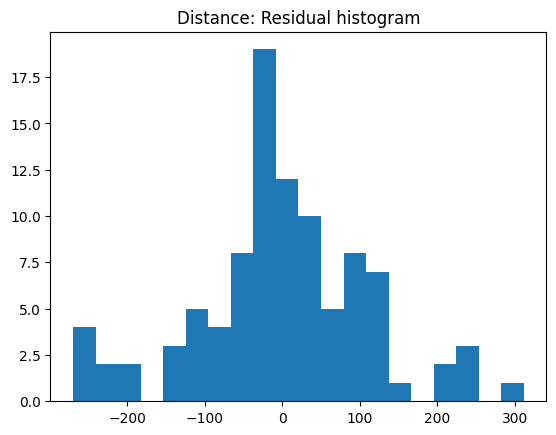

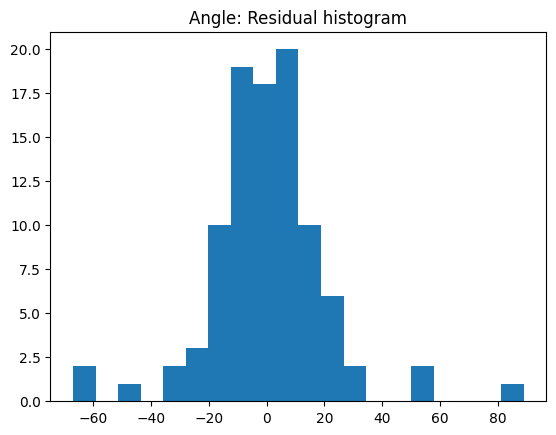

In [16]:
plt.hist(m_dist.resid, bins=20)
plt.title("Distance: Residual histogram")
plt.show()

plt.hist(m_ang.resid, bins=20)
plt.title("Angle: Residual histogram")
plt.show()


###ANALISYS OF RESIDUALS FOR DISTANCE

The residuals-versus-fitted plot suggests that the **linear mean structure of the model is reasonable,** as no strong systematic patterns are observed. However, a **slight increase in residual spread** for larger fitted values can be noted, indicating **mild heteroscedasticity.**

The **Q–Q plot reveals substantial deviations from normality,** particularly in the tails, and the residual histogram confirms the presence of heavy-tailed behavior. This is consistent with the physical nature of the system, in which a small number of experimental runs produce exceptionally long flight distances.

Although linear modeling remains appropriate for effect screening, these diagnostic results suggest that a **transformation of the distance response (e.g., logarithmic)** may improve the distributional properties of the residuals. This will be explored in subsequent model refinement.



In [17]:
#lets try to log fit
import numpy as np

model_df["logDistance"] = np.log(model_df["Distance"])
formula_logdist = "logDistance ~ Day + (A + B + Ang + H + S)**2"
m_logdist = smf.ols(formula_logdist, data=model_df).fit()
print(m_logdist.summary())


                            OLS Regression Results                            
Dep. Variable:            logDistance   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     4.585
Date:                Thu, 15 Jan 2026   Prob (F-statistic):           1.19e-06
Time:                        09:02:11   Log-Likelihood:                -51.834
No. Observations:                  96   AIC:                             141.7
Df Residuals:                      77   BIC:                             190.4
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6446      0.095     59.647      0.0

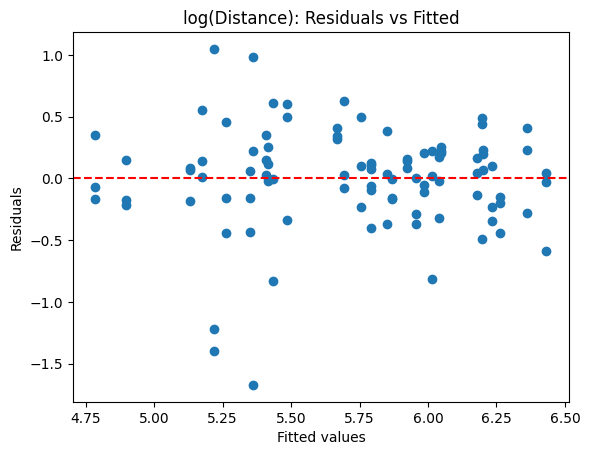

In [18]:
plt.scatter(m_logdist.fittedvalues, m_logdist.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("log(Distance): Residuals vs Fitted")
plt.show()


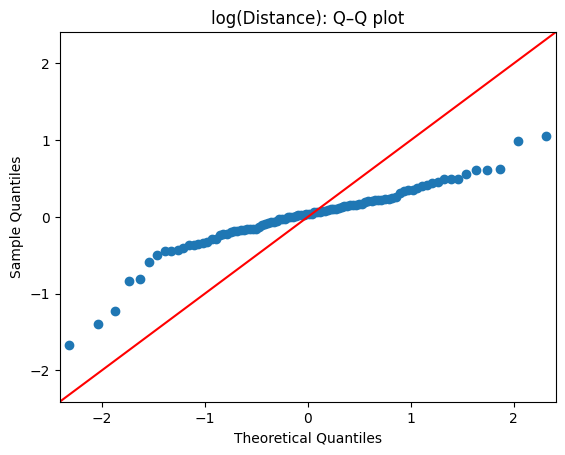

In [19]:
sm.qqplot(m_logdist.resid, line='45')
plt.title("log(Distance): Q–Q plot")
plt.show()


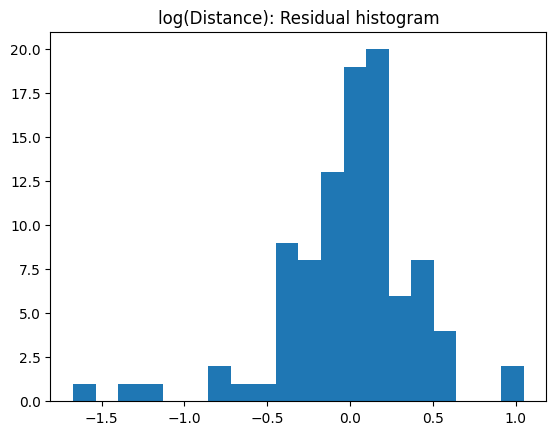

In [20]:
plt.hist(m_logdist.resid, bins=20)
plt.title("log(Distance): Residual histogram")
plt.show()


###INTERPRETATION OF THE LOG-DISTANCE MODEL
The **logarithmic transformation substantially improved the distributional properties of the residuals,** reducing skewness and stabilizing variance. While mild deviations from normality remain, the assumptions of linear regression are now reasonably satisfied for screening and inference purposes. This is **clearly seen in Q-Q plot**, for example.

---

**Significant effects in log(distance) model**
| Term           | p-value | Effect          |
| -------------- | ------- | --------------- |
| A (Plane type) | < 0.001 | very strong     |
| B (Mass)       | 0.015   | significant     |
| H (Height)     | 0.019   | significant     |
| S (Speed)      | 0.006   | significant     |
| Ang            | 0.703   | not significant |

We still have same values as before, which is very convinient.

---

**Significant iteractions in log(distance) model**
| Term   | p-value | Keep? |
| ------ | ------- | ----- |
| A:B    | 0.023   | YES   |
| Ang:S  | 0.008   | YES   |
| Others | > 0.1   | No    |

---

**Summary**

The original distance model exhibited heavy-tailed residuals and deviations from normality, as indicated by the Q–Q plot and residual histogram. This behavior is consistent with the physical nature of the system, in which rare factor combinations can lead to exceptionally long flights.

To address these issues, a **logarithmic transformation of the distance response was applied.** The transformed model shows substantial improvement in residual behavior, with more symmetric distributions, reduced tail heaviness, and more homogeneous variance. While mild deviations from normality remain, the assumptions of linear regression are now reasonably satisfied, making the **transformed model more appropriate** for inference and effect screening.

So, **from this point we will use log(distance) model** for distance. It is important to know how to interpret the factors.
Because the distance response was modeled on a logarithmic scale, the regression coefficients no longer represent additive changes in the original distance units. Instead, they describe multiplicative effects. Specifically, each coefficient corresponds to a proportional change in the expected flight distance when the associated factor changes from its low level (−1) to its high level (+1), while holding all other factors constant.

Exponentiating a coefficient gives the relative change in distance. For example, a coefficient of −0.30 implies that switching from the low to the high level of that factor multiplies the expected distance by exp(−0.30) ≈ 0.74, corresponding to an approximate 26% decrease. This interpretation is particularly suitable for physical systems, where responses often scale multiplicatively rather than additively.


###ANALYSIS OF RESIDUALS FOR ANGLE

The residual diagnostics for the trajectory angle model reveal **noticeable deviations from the assumptions of linear regression.** The residuals-versus-fitted plot suggests increasing variance for larger fitted values, indicating **heteroscedasticity.** The Q–Q plot shows strong departures from normality, with heavy tails and several extreme observations. This behavior is further confirmed by the residual histogram, which displays asymmetry and a pronounced tail structure.

Such behavior is not unexpected for angular responses in physical systems, where rare configurations may produce extreme trajectories. While the linear model remains useful for screening purposes and for identifying dominant factors and interactions, these diagnostic results indicate that statistical inference should be interpreted cautiously.

As angle is not as easy to transformate as distance, **we will keep this raw model for out analysis.** However, we have to, at all time, take into account the non normality of our problem and take into account that derived conclusions may not be correct.

###REDUCED MODELS AND FINAL EFFECT INTERPRETATION

The initial factorial models included all main effects, two-factor interactions, and the blocking variable. While this comprehensive structure is appropriate for screening purposes, it often leads to models that are unnecessarily complex and difficult to interpret. Many of the included terms may not contribute meaningfully to the explanation of the responses, and retaining them can obscure the true drivers of system behavior.

To obtain more interpretable and practically useful models, a **model reduction step was performed.** This process consists of retaining only the statistically significant and scientifically meaningful terms while respecting the principle of hierarchy: whenever an interaction is included, the corresponding main effects are also retained. The block factor (day) is preserved in all models as a nuisance variable to account for potential day-to-day variability.

Separate reduced models are constructed for each response variable: log-transformed flight distance and trajectory angle. These final models aim to provide a clear representation of the dominant factors and interactions governing each response, facilitating physical interpretation, comparison between responses, and identification of promising directions for further experimentation, such as the inclusion of center points.

---

**log(distance)**

Main effects:

- A (Plane type)

- B (Mass)

- H (Height)

- S (Speed)

Interactions:

- A × B

- Ang × S

Block:

- Day (keep it as a nuisance term)

---

**Angle**

Main effects:

- A (Plane type)

- B (Mass)

- H (Height)

- (Ang is borderline — we’ll test it)

Interactions:

- A × B

- A × H

- B × Ang

Block:

- Day (keep)


In [21]:
#fit the reduced log-distance model
formula_logdist_reduced = "logDistance ~ Day + A + B + H + S + Ang + A:B + Ang:S"
m_logdist_reduced = smf.ols(formula_logdist_reduced, data=model_df).fit()
print(m_logdist_reduced.summary())


                            OLS Regression Results                            
Dep. Variable:            logDistance   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     8.227
Date:                Thu, 15 Jan 2026   Prob (F-statistic):           3.52e-09
Time:                        09:02:12   Log-Likelihood:                -54.303
No. Observations:                  96   AIC:                             130.6
Df Residuals:                      85   BIC:                             158.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6446      0.092     61.078      0.0

In [22]:
#anova for reduced log distance model
anova_logdist_red = sm.stats.anova_lm(m_logdist_reduced, typ=2)
anova_logdist_red.sort_values("PR(>F)")

,sum_sq,df,F,PR(>F)
A,9.619234,1.0,46.928979,1.090500e-09
S,1.685433,1.0,8.222658,5.215427e-03
Ang:S,1.607210,1.0,7.841031,6.320717e-03
B,1.320670,1.0,6.443099,1.296135e-02
H,1.230574,1.0,6.003555,1.632810e-02
A:B,1.150756,1.0,5.614149,2.008133e-02
Ang,0.031455,1.0,0.153457,6.962341e-01
Day,0.217814,3.0,0.354214,7.861992e-01
Residual,17.422814,85.0,NaN,NaN


###REDUCED MODEL FOR LOG(DISTANCE)

A reduced factorial model was fitted for the logarithm of flight distance by retaining only the statistically significant and hierarchically necessary terms. The resulting model **explains approximately 49% of the total variability** and remains **highly significant** (p < 10⁻⁸), indicating that the retained factors capture the dominant physical drivers of flight performance.

Plane type (A) was found to be the most influential factor. Switching from the dart-style design to the glider design resulted in an approximate 27% reduction in expected flight distance. Mass (B) also exhibited a significant negative effect, with heavier airplanes reducing distance by approximately 11%. Both launch height (D) and throw speed (E) had significant positive effects, increasing expected distance by approximately 12% and 14%, respectively.

Two interaction effects were also significant. The A×B interaction indicates that the negative effect of the glider design is amplified at higher mass levels. The Ang×S interaction reveals that the benefit of increasing throw speed depends strongly on the launch angle, highlighting the importance of combined factor settings rather than independent optimization.

The block factor (day) was retained as a nuisance variable to account for potential day-to-day variability, although it was not statistically significant in the reduced model.

Lets analyse the factors:

A = -0.3165

exp(-0.3165) = 0.7229


➡️ Switching from Dard (−1) to Glider (+1) reduces distance by ~27%

B = -0.1173

exp(−0.1173)=0.889

➡️ Heavier mass reduces distance by ~11%

H = 0.1132

exp(0.1132)=1.120

➡️ Higher launch height increases distance by ~12%

S = 0.1325

exp(0.1325)=1.142

➡️ Higher throw speed increases distance by ~14%

A × B = −0.1095

This means the penalty of glider design becomes worse when mass is high.

Ang × S = +0.1294

This means the benefit of increasing speed depends strongly on launch angle.

In [23]:
#fit the reduced angle model
formula_ang_reduced = "Angle ~ Day + A + B + H + Ang + A:B + A:H + B:Ang"
m_ang_reduced = smf.ols(formula_ang_reduced, data=model_df).fit()
print(m_ang_reduced.summary())


                            OLS Regression Results                            
Dep. Variable:                  Angle   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     9.547
Date:                Thu, 15 Jan 2026   Prob (F-statistic):           1.84e-10
Time:                        09:02:12   Log-Likelihood:                -434.67
No. Observations:                  96   AIC:                             891.3
Df Residuals:                      85   BIC:                             919.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.2083      4.859      4.571      0.0

In [24]:
#anova for reduced angle model
anova_ang_red = sm.stats.anova_lm(m_ang_reduced, typ=2)
anova_ang_red.sort_values("PR(>F)")

,sum_sq,df,F,PR(>F)
B,15125.260417,1.0,26.698443,0.000002
A:B,14528.760417,1.0,25.645528,0.000002
A,13704.260417,1.0,24.190157,0.000004
H,3516.260417,1.0,6.206748,0.014670
A:H,2291.260417,1.0,4.044432,0.047486
B:Ang,2156.510417,1.0,3.806577,0.054346
Ang,1953.010417,1.0,3.447368,0.066817
Day,810.781250,3.0,0.477052,0.699093
Residual,48154.385417,85.0,NaN,NaN


###REDUCED MODEL FOR ANGLE
A reduced factorial model was fitted for the trajectory angle by retaining only the statistically significant and hierarchically necessary terms. The resulting model **explains approximately 53% of the observed variability** and remains **highly significant** (p < 10⁻⁹), indicating that the selected factors capture the dominant mechanisms governing flight orientation.

Plane type (A) and mass (B) were found to be the most influential main effects. The glider configuration produced trajectories that were, on average, approximately 12 degrees steeper than the dart design, while heavier airplanes exhibited flatter trajectories by approximately 12.5 degrees. Launch height (D) also had a significant positive effect, increasing the trajectory angle by roughly 6 degrees.

Several interaction effects were identified as important. The strong A×B interaction indicates that the influence of plane type is strongly dependent on mass, with heavier gliders producing much flatter trajectories. The A×D interaction suggests that the effect of plane design is amplified at higher launch heights. The B×C interaction, although borderline significant, was retained due to hierarchy and indicates that the influence of launch angle depends on the mass level.

The block factor (day) was not statistically significant, but was retained to preserve the experimental structure.

Here coefficients are additive.

A = +11.95

➡️Switching from Dard (−1) to Glider (+1) increases the angle by ~12 degrees.

B = −12.55

➡️Heavier airplanes reduce angle by ~12.5 degrees.

H = +6.05

➡️Higher launch height increases angle by ~6 degrees.

A × B = −12.30

➡️This means the effect of plane type strongly depends on mass.
The glider becomes much flatter when heavy.

A × H = +4.89

➡️The effect of plane type depends on height — gliders become steeper when launched from higher positions.

B × Ang = −4.74

➡️The effect of launch angle depends on mass.

###MAIN INTERACTION EFFECTS

While main effects describe the average influence of each factor on the response, they do not capture how the effect of one factor may depend on the level of another. In many physical systems, such dependencies are common, and ignoring them can lead to misleading conclusions. Interaction effects are therefore a central component of factorial experiments, as they reveal coupled mechanisms and conditional behaviors.

In this section, the most important interaction terms identified in the reduced models are examined using **interaction plots.** These visualizations allow for intuitive interpretation of how factor combinations jointly influence the responses, providing insights that are not evident from main effects alone. Special attention is given to identifying conflicting trends between flight distance and trajectory angle, as these trade-offs highlight the multi-objective nature of the design problem.

Understanding these interactions is essential for developing practical design rules and for selecting appropriate factors for further refinement through center-point experiments or response surface modeling.

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def interaction_plot(df, x, trace, y, title):
    for level in [-1, 1]:
        subset = df[df[trace] == level]
        means = subset.groupby(x)[y].mean()
        plt.plot(means.index, means.values, marker='o', label=f"{trace} = {level}")

    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


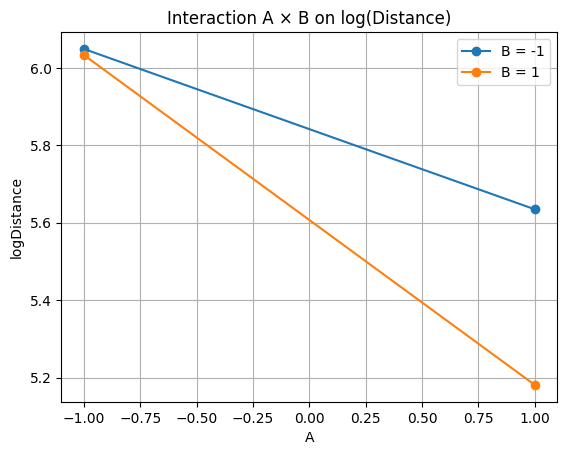

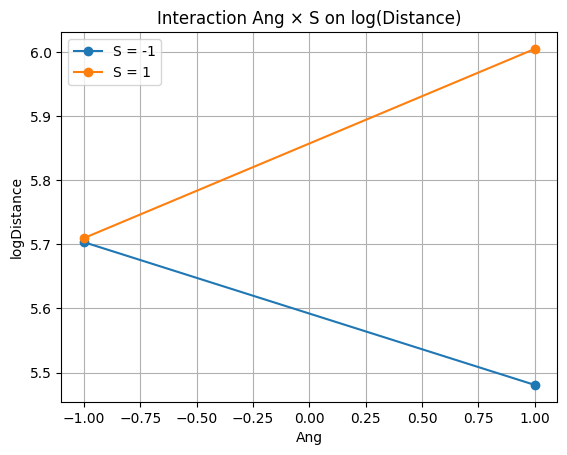

In [26]:
interaction_plot(model_df, x="A", trace="B", y="logDistance",
                 title="Interaction A × B on log(Distance)")

interaction_plot(model_df, x="Ang", trace="S", y="logDistance",
                 title="Interaction Ang × S on log(Distance)")


###INTERPRETATION OF DISTANCE INTERACTIONS

**Interaction between Plane Type (A) and Mass (B) on log(Distance)**

The interaction plot between plane type and mass shows a **strong non-parallel behavior,** confirming the presence of a significant interaction effect. For the lighter airplane configuration (B = −1), switching from the dart design (A = −1) to the glider design (A = +1) results in a moderate reduction in flight distance. However, for the heavier configuration (B = +1), this reduction is substantially more pronounced.

This indicates that the negative impact of the glider design on distance is amplified when the airplane is heavier. In other words, while both plane types perform worse at higher mass levels, the glider configuration is particularly sensitive to added weight. This suggests that the **aerodynamic advantages of the glider design are offset by increased mass,** leading to a stronger performance penalty.

---

**Interaction between Launch Angle (Ang) and Throw Speed (S) on log(Distance)**

The interaction plot between launch angle and throw speed exhibits a clear crossing pattern, indicating a strong interaction. **When the throw speed is low (S = −1), increasing the launch angle from 0° to 45° slightly decreases the expected flight distance. In contrast, when the throw speed is high (S = +1), increasing the launch angle leads to a noticeable improvement in distance.**

This implies that the benefit of launching at 45° is conditional on having sufficient initial speed. At low speeds, a higher launch angle may cause the airplane to lose horizontal momentum too quickly, whereas at higher speeds, the additional lift associated with a steeper launch becomes advantageous. This interaction highlights the importance of considering joint factor settings rather than optimizing each factor independently.

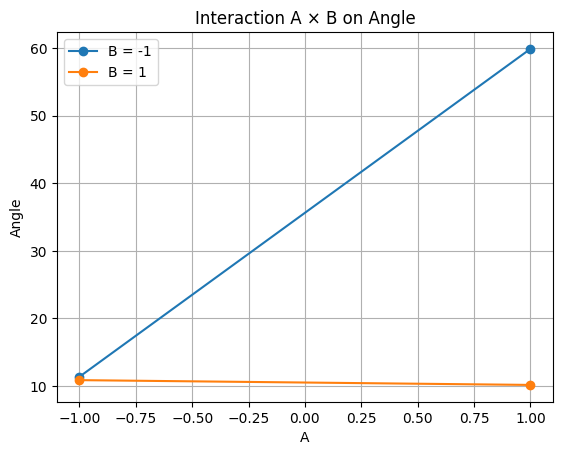

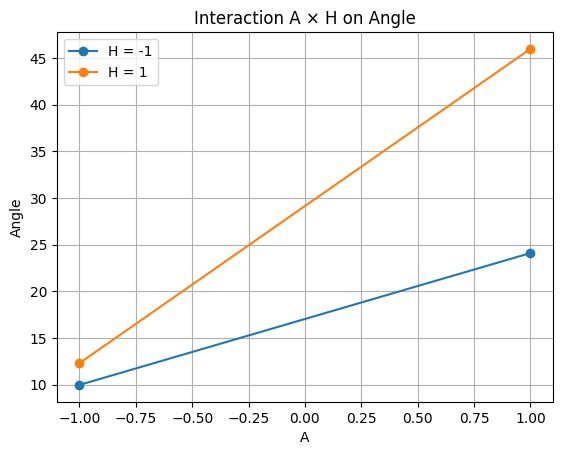

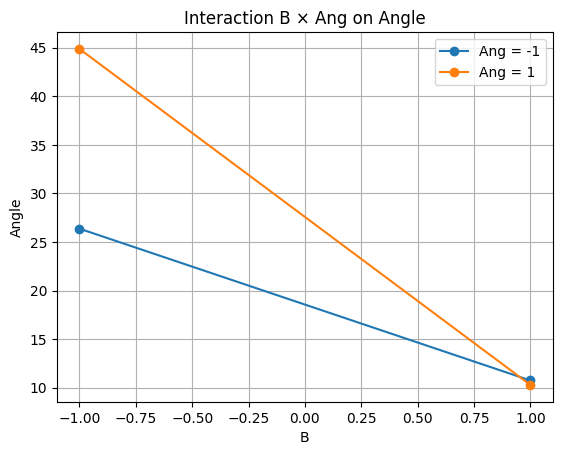

In [27]:
#plot angle interactions
interaction_plot(model_df, x="A", trace="B", y="Angle",
                 title="Interaction A × B on Angle")

interaction_plot(model_df, x="A", trace="H", y="Angle",
                 title="Interaction A × H on Angle")

interaction_plot(model_df, x="B", trace="Ang", y="Angle",
                 title="Interaction B × Ang on Angle")


###INTERPRETATION OF ANGLE INTERACTIONS

**Interaction between Plane Type (A) and Mass (B) on Angle**

This interaction is extremely strong and visually striking. **For the lighter configuration (B = −1), switching from the dart design (A = −1) to the glider design (A = +1) results in a dramatic increase in trajectory angle. In contrast, for the heavier configuration (B = +1), the angle remains low and almost unchanged across plane types.**

This indicates that the glider design only produces steep trajectories when the airplane is light. When mass is increased, the aerodynamic advantages of the glider design are largely suppressed, leading to flatter and more stable trajectories. This interaction reveals that plane type and mass must be considered jointly when analyzing flight behavior.

---

**Interaction between Plane Type (A) and Launch Height (H) on Angle**

The interaction between plane type and launch height shows that the effect of plane design is amplified at higher launch heights. **While both plane types exhibit an increase in angle when launched from a higher position, this increase is much more pronounced for the glider design.**

This suggests that the glider configuration is particularly sensitive to changes in launch height, likely due to its increased lift and longer time aloft. In contrast, the dart design remains comparatively stable across heights. This interaction highlights that design-dependent aerodynamic behavior becomes more pronounced when the plane has more time to evolve dynamically.

---

**Interaction between Mass (B) and Launch Angle (Ang) on Angle**

This interaction shows that the effect of launch angle depends strongly on mass. **For the lighter configuration (B = −1), increasing the launch angle from 0° to 45° leads to a large increase in the observed trajectory angle. However, for the heavier configuration (B = +1), the effect of launch angle is much weaker, and the resulting trajectory remains relatively flat.**

This implies that lighter airplanes are much more responsive to changes in launch orientation, while heavier airplanes dampen these effects. From a physical perspective, this is consistent with higher inertia reducing sensitivity to initial conditions.

---

**Key Behavioral Insights for Angle**

These interactions demonstrate that trajectory angle is governed by strongly coupled effects. In particular:

- The glider design produces steep trajectories only when the airplane is light.

- Increasing launch height amplifies the aerodynamic differences between designs.

- The effect of launch angle is strongest for lighter airplanes.

This confirms that trajectory behavior cannot be predicted from main effects alone and that joint factor settings must be considered.

###TRADE-OFFS BETWEEN ANGLE AND DISTANCE

Because this study includes two responses (flight distance and trajectory angle), the “best” factor settings depend on the goal. Maximizing distance alone may produce unstable or steep trajectories, while minimizing angle alone may lead to shorter flights. Therefore, the results are interpreted as a multi-objective design problem: we seek settings that produce large distance while maintaining a reasonably stable trajectory.

1. **Plane type (A): performance vs stability conflict**

- Distance: The dart design (A = −1) clearly performs better: switching to the glider (A = +1) reduces log(distance) substantially (≈ 27% decrease in expected distance from the reduced model).

- Angle: The glider (A = +1) produces much steeper trajectories (≈ +12° main effect) and much higher variability.
Trade-off: The dart is best for distance and stability; the glider tends to increase trajectory angle and reduce distance, especially when heavy.

- Practical conclusion: If the objective is “long and stable flight,” A = −1 (dart) is the most robust choice.

2. **Mass (B): longer distance vs steeper behavior (conditional)**

- Distance: Higher mass (B = +1) reduces distance (≈ 11% decrease).

- Angle: Higher mass reduces trajectory angle (≈ −12.5°), meaning flatter and more stable trajectories.

- Trade-off: Light planes fly farther but tend to have steeper/more variable trajectories; heavy planes are more stable but travel less far.

3. **Interaction insight (A×B)**

The glider becomes particularly poor for distance when heavy, and the “steep glider” behavior appears mainly when the plane is light.

Practical conclusion: If you choose the dart design, a lighter mass is generally preferred for distance. If stability is prioritized, increasing mass can flatten trajectories, but at the cost of range.

4. **Launch height (H): increases distance and increases angle**

- Distance: Higher height increases distance (≈ +12%).

- Angle: Higher height also increases angle (≈ +6°) and amplifies the glider’s steepness (A×H interaction).

- Trade-off: Height improves distance but can worsen trajectory steepness, particularly for the glider.

- Practical conclusion: Higher height is generally beneficial, but if you want stability, combine high height with the dart design, not the glider.

5. **Throw speed (S) and launch angle (Ang): the key conditional trade-off**

Do not forget we have an strong Ang×S interaction on distance:

- When speed is low, increasing launch angle to 45° does not help distance (it can slightly reduce it).

- When speed is high, increasing launch angle to 45° strongly increases distance.

For trajectory angle:

- Speed is not a strong main effect in the reduced angle model, but angle behavior still shows heavy tails and variability.

Practical conclusion:
- If you can throw fast, use Ang = +1 (45°) to boost distance.
- If the throw is slow/variable, Ang = −1 (0°) is safer and more consistent.

**Summary: “Good settings” depending on objective**

If the objective is maximum distance (performance-first):

- A = −1 (dart)

- B = −1 (light)

- H = +1 (high)

- S = +1 (high)

- Ang depends on speed: use Ang = +1 when S is high

If the objective is stable trajectory (angle-first):

- B = +1 (heavy) (flatter trajectories)

- A = −1 (dart) (more stable than glider)

- Ang = −1 (0°) tends to avoid steep outcomes

- Moderate height/speed if extreme angles are a concern

Balanced recommendation (distance + stability)

A robust compromise suggested by both models is:

- A = −1 (dart)

- B = −1 (light) (for distance)

- H = +1 (high)

- S = +1 (high)

- Ang = +1 (45°) only if you can reliably throw fast; otherwise Ang = −1

###CENTER POINTS AND RESPONSE SURFACE EXPLORATION

After identifying the most influential factors and interactions through the factorial screening analysis, the next step is to explore potential curvature in the response and to move toward a more detailed optimization of the system. Two-level factorial designs are well suited for detecting linear trends and interactions, but they are unable to capture nonlinear behavior. In physical systems such as paper airplane flight, curvature is often expected, particularly near optimal operating conditions.

To address this, **center points were introduced for the most relevant continuous factors: launch angle (C), launch height (D), and mass (B).** Specifically, the following mid-levels were selected:

- Launch angle: 22.5° (midpoint between 0° and 45°),

- Launch height: 92.5 cm (midpoint between 55 cm and 130 cm),

- Mass: 5.25 g (midpoint between 3.5 g and 7 g).

These values represent physically meaningful intermediate settings that can be implemented reliably in practice. **Throw speed was retained as a two-level factor due to the difficulty of setting a reproducible intermediate level.**

Using these center points, a response surface design was constructed, allowing the fitting of second-order (quadratic) models. This enables the generation of contour plots and response surfaces, which provide a visual representation of how the responses vary smoothly as a function of the experimental factors. These plots allow for the identification of local optima and the visualization of trade-offs between distance and trajectory angle.

This stage of the analysis shifts the focus from factor screening to optimization and fine-tuning, providing deeper insight into the behavior of the system near its best-performing configurations.

In [28]:
#we have to upload data collected for midpoint and optimal configuration
import pandas as pd
import numpy as np

# ✅ Use RAW link (not /blob/)
url = "https://raw.githubusercontent.com/oihanetxu52-cmd/paper_airplanes/main/contour_experiment_runsheet_CCD_with_optima.xlsx"

df_raw = pd.read_excel(url, sheet_name="RunSheet_SingleColumn")

single_col = df_raw.columns[0]
df_split = df_raw[single_col].astype(str).str.split(",", expand=True)

# trailing comma creates an extra empty column -> keep first 12 fields
df_split = df_split.iloc[:, :12]

df_split.columns = [
    'Plane_Type',
    'Mass_Level',
    'Launch_Angle_deg',
    'Launch_Height',
    'Throw_Speed',
    'Config_ID',
    'Day',
    'Order_in_Day',
    'Replicate',
    'Radial_Distance_cm',
    'Trajectory_Angle_deg',
    'Notes'
]

# Convert numeric columns
numeric_cols = [
    'Launch_Angle_deg','Config_ID','Day','Order_in_Day','Replicate',
    'Radial_Distance_cm','Trajectory_Angle_deg'
]
for col in numeric_cols:
    df_split[col] = pd.to_numeric(df_split[col], errors='coerce')

df_split.head()



,Plane_Type,Mass_Level,Launch_Angle_deg,Launch_Height,Throw_Speed,Config_ID,Day,Order_in_Day,Replicate,Radial_Distance_cm,Trajectory_Angle_deg,Notes
0,A,Mid(5.25g),22.5,High,Low,201,1,1,1,354.40090,18,CCD point (B=0; C=0; D=1) at Low speed
1,A,Mid(5.25g),45.0,Mid(92.5cm),Low,202,1,2,1,358.24010,6,CCD point (B=0; C=1; D=0) at Low speed
2,A,Mid(5.25g),22.5,Mid(92.5cm),Low,203,1,3,1,414.30420,5,CCD point (B=0; C=0; D=0) at Low speed
3,A,Normal,45.0,Low,Low,204,1,4,1,462.08224,6,CCD point (B=-1; C=1; D=-1) at Low speed
4,A,Mid(5.25g),22.5,Mid(92.5cm),Low,205,1,5,1,214.20600,8,CCD point (B=0; C=0; D=0) at Low speed


In [29]:
#lets do some checks
print("Rows, Cols:", df_split.shape)
print("\nMissing rate:")
print(df_split[['Radial_Distance_cm','Trajectory_Angle_deg']].isna().mean())

#At least, it seems that all the data is available


Rows, Cols: (42, 12)

Missing rate:
Radial_Distance_cm      0.0
Trajectory_Angle_deg    0.0
dtype: float64


In [30]:
#to do the contour models, we will convert mass and height to numerical values
# Map your labels to numeric values

mass_to_g = {"Normal": 3.5, "Mid(5.25g)": 5.25, "Double": 7.0}
height_to_cm = {"Low": 55.0, "Mid(92.5cm)": 92.5, "High": 130.0}

df = df_split.copy()
df["Mass_g"] = df["Mass_Level"].map(mass_to_g)
df["Height_cm"] = df["Launch_Height"].map(height_to_cm)
df["Angle_deg"] = df["Launch_Angle_deg"]
df["Speed"] = df["Throw_Speed"]


In [31]:
# we will fit quadratic response-surface models with separated speed
import statsmodels.formula.api as smf

def fit_quadratic(data, response):
    formula = (
        f"{response} ~ Mass_g + Angle_deg + Height_cm"
        " + I(Mass_g**2) + I(Angle_deg**2) + I(Height_cm**2)"
        " + Mass_g:Angle_deg + Mass_g:Height_cm + Angle_deg:Height_cm"
    )
    return smf.ols(formula, data=data).fit()

models = {}

for sp in ["Low", "High"]:
    dsub = df[df["Speed"] == sp].copy()

    # Distance model
    dist_data = dsub.dropna(subset=["Radial_Distance_cm"])
    models[(sp, "Distance")] = fit_quadratic(dist_data, "Radial_Distance_cm")

    # Angle model
    ang_data = dsub.dropna(subset=["Trajectory_Angle_deg"])
    models[(sp, "Angle")] = fit_quadratic(ang_data, "Trajectory_Angle_deg")

for k, m in models.items():
    print(k, "n=", int(m.nobs), "R2=", round(m.rsquared, 3))


('Low', 'Distance') n= 20 R2= 0.774
('Low', 'Angle') n= 20 R2= 0.697
('High', 'Distance') n= 22 R2= 0.757
('High', 'Angle') n= 22 R2= 0.336


###INTERPRETATION OF NEW QUADRATIC MODELS
This is the data we have:
| Speed | Response | n  | R²    | Interpretation  |
| ----- | -------- | -- | ----- | --------------- |
| Low   | Distance | 20 | 0.774 | Very good fit |
| Low   | Angle    | 20 | 0.697 | Good fit      |
| High  | Distance | 22 | 0.757 | Very good fit |
| High  | Angle    | 22 | 0.336 | Weak fit     |

The distance response exhibits smooth, well-defined curvature that can be modeled accurately using a quadratic surface. In contrast, the **trajectory angle response—especially at high speed—shows much higher variability and weaker predictability,** indicating a more chaotic and sensitive dynamic regime.

Note that the n is different, this is because in data generation there may have been an error. There is no problem with that, we will just use the information available.

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def predict_grid(model, mass_g, angle_range=(0,45), height_range=(55,130), n=80):
    ang = np.linspace(angle_range[0], angle_range[1], n)
    h = np.linspace(height_range[0], height_range[1], n)
    A, H = np.meshgrid(ang, h)

    grid = pd.DataFrame({
        "Mass_g": mass_g,
        "Angle_deg": A.ravel(),
        "Height_cm": H.ravel()
    })

    Z = model.predict(grid).values.reshape(H.shape)
    return A, H, Z

def contour_plot(model, title, mass_g=5.25):
    A, H, Z = predict_grid(model, mass_g=mass_g)

    plt.figure()
    cs = plt.contour(A, H, Z, levels=12)
    plt.clabel(cs, inline=True, fontsize=8)
    plt.xlabel("Launch angle (deg)")
    plt.ylabel("Launch height (cm)")
    plt.title(f"{title} (Mass = {mass_g} g)")
    plt.grid(True)
    plt.show()


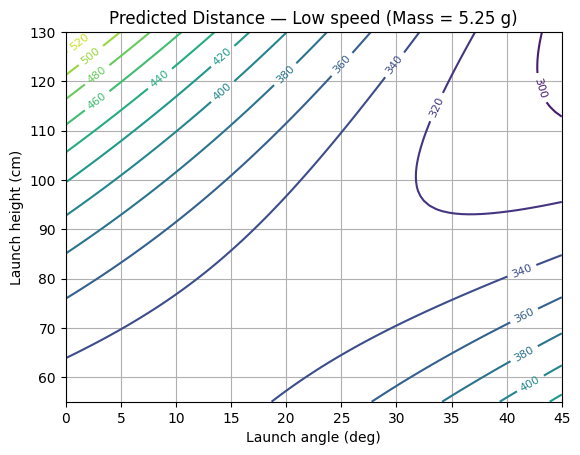

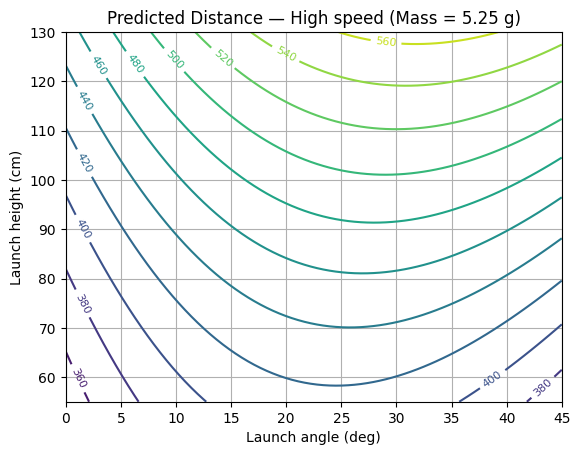

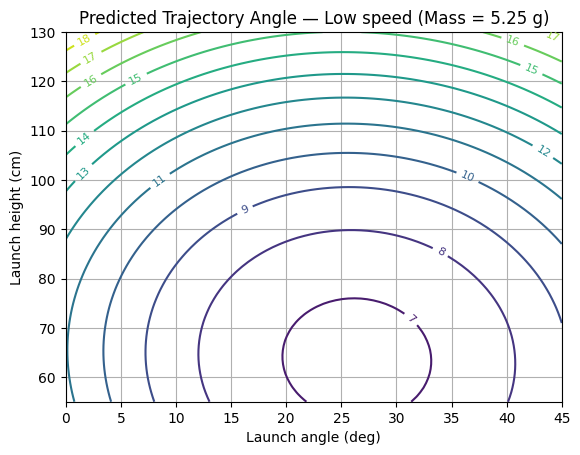

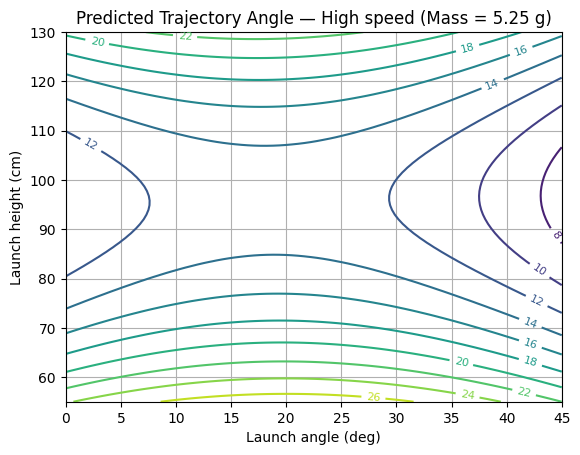

In [33]:
#Lets now do the contour plots
# Distance contours
contour_plot(models[("Low","Distance")],  "Predicted Distance — Low speed",  mass_g=5.25)
contour_plot(models[("High","Distance")], "Predicted Distance — High speed", mass_g=5.25)

# Angle contours
contour_plot(models[("Low","Angle")],  "Predicted Trajectory Angle — Low speed",  mass_g=5.25)
contour_plot(models[("High","Angle")], "Predicted Trajectory Angle — High speed", mass_g=5.25)


###INTERPRETATION OF CONTOUR PLOTS

**Predicted Distance — Low Speed (Mass = 5.25 g)**

At low throw speed, the predicted distance surface exhibits a clear **monotonic trend with respect to launch height:** increasing the launch height consistently improves flight distance across nearly the entire range of launch angles. The influence of launch angle is weaker and more conditional. For small angles (close to 0°), distance increases steadily with height, whereas for larger angles (approaching 45°), the distance begins to decrease slightly, especially at intermediate heights.

This suggests that, **at low speeds, the airplane does not have sufficient kinetic energy to benefit from steep launch angles.** Instead, horizontal travel is favored by shallow launches combined with higher initial potential energy (greater height). In this regime, the system behaves more like a ballistic object than a lifting glider.

---

 **Predicted Distance — High Speed (Mass = 5.25 g)**

At high speed, the distance surface becomes much more structured and curved. **A pronounced ridge appears around intermediate launch angles (roughly 20–30°), particularly at high launch heights.** This indicates the presence of a local optimum rather than a simple monotonic trend.

Unlike the low-speed case, the airplane now benefits from a combination of sufficient horizontal velocity and aerodynamic lift, making intermediate launch angles more favorable. The interaction between speed and launch angle identified earlier is clearly visible here: at high speed, increasing the launch angle no longer harms performance, but instead contributes positively up to an optimal region.

This surface confirms that, under high-speed conditions, the flight distance is governed by a balance between lift generation and forward momentum.

---

**Predicted Trajectory Angle — Low Speed (Mass = 5.25 g)**

The low-speed trajectory angle surface displays a smooth, bowl-shaped structure, with a **minimum located at intermediate angles and moderate heights.** This suggests that stable, shallow trajectories occur near the center of the design space.

At low speeds, both very small and very large launch angles lead to steeper trajectories, while moderate angles produce flatter and more stable flight paths. Increasing launch height tends to increase the trajectory angle slightly, but this effect remains smooth and predictable.

This well-behaved surface is consistent with the relatively high R² of the low-speed angle model and indicates that, in this regime, the system is stable and easily predictable.

---

**Predicted Trajectory Angle — High Speed (Mass = 5.25 g)**

In contrast, the high-speed trajectory angle surface is much more **irregular.** The contours are less symmetric, and the surface exhibits complex curvature patterns. This reflects the low R² value obtained for this model and confirms that the trajectory angle becomes more sensitive and less predictable at high speeds.

Physically, this is expected: higher speeds amplify aerodynamic instabilities, small variations in launch conditions, and nonlinear effects such as stall, turbulence, and asymmetric folding imperfections. As a result, even small changes in angle or height can lead to disproportionately large changes in trajectory angle.

This behavior highlights a fundamental trade-off: while high speed improves distance, it reduces the predictability and stability of the trajectory.

---

**Global Interpretation and Trade-offs**

Together, these contour plots illustrate a key finding of this study: the conditions that maximize distance are not necessarily those that minimize trajectory angle.

- High speed enables long flights but introduces greater variability and steeper or more erratic trajectories.

- Low speed yields more stable and predictable trajectories but limits achievable distance.

- Higher launch heights almost always benefit distance, but they also tend to increase trajectory angle.

Optimal launch angles depend strongly on speed: shallow angles are best at low speed, while intermediate angles are best at high speed.

This confirms that the paper airplane system is inherently multi-objective, with competing performance metrics.

---

**Optimization Insight**

Rather than identifying a single “best” configuration, these surfaces reveal optimal regions.

- For maximum distance at high speed:
High launch height and intermediate launch angle form a ridge of high performance.

- For stable trajectories at low speed:
Moderate angles and moderate heights form a basin of low trajectory angle.

- For a balanced compromise between distance and stability:
One should avoid extreme settings and operate near the center of the design space.

This surface-based perspective is far more informative than single-point optimization and highlights the strength of response surface methodology in experimental design.

In [34]:
#We are now going to predict optimum configuration
import numpy as np
import pandas as pd

bounds = {
    "Mass_g": (3.5, 7.0),
    "Angle_deg": (0, 45),
    "Height_cm": (55, 130)
}

def grid_search_opt(model, n=70):
    mg = np.linspace(*bounds["Mass_g"], n)
    ang = np.linspace(*bounds["Angle_deg"], n)
    h  = np.linspace(*bounds["Height_cm"], n)

    MG, ANG, H = np.meshgrid(mg, ang, h, indexing="ij")
    grid = pd.DataFrame({
        "Mass_g": MG.ravel(),
        "Angle_deg": ANG.ravel(),
        "Height_cm": H.ravel()
    })

    pred = model.predict(grid).values
    i = int(np.argmax(pred))
    return {
        "Mass_g": float(grid.iloc[i]["Mass_g"]),
        "Angle_deg": float(grid.iloc[i]["Angle_deg"]),
        "Height_cm": float(grid.iloc[i]["Height_cm"]),
        "Predicted": float(pred[i])
    }

opt_low_dist  = grid_search_opt(models[("Low","Distance")],  n=70)
opt_high_dist = grid_search_opt(models[("High","Distance")], n=70)

print("Optimum Distance (Low speed): ", opt_low_dist)
print("Optimum Distance (High speed):", opt_high_dist)


Optimum Distance (Low speed):  {'Mass_g': 6.086956521739131, 'Angle_deg': 0.0, 'Height_cm': 130.0, 'Predicted': 539.2507699487613}
Optimum Distance (High speed): {'Mass_g': 3.5, 'Angle_deg': 24.130434782608695, 'Height_cm': 130.0, 'Predicted': 688.2738996287774}


###PREDICTED BEST OPTION FOR DISTANCE

The response surface models indicate that maximum flight distance occurs at high launch height in both regimes. However, the optimal launch angle depends strongly on speed: at low speed the best performance is obtained with a shallow launch (0°), while at high speed the optimum shifts to an intermediate angle (~22.5–25°), consistent with the presence of curvature and the previously identified Angle×Speed interaction.

##TESTING (for intial model without midle points)
Before constructing the response surface model, two promising configurations predicted from the factorial screening stage were experimentally tested. These confirmation runs provide an early validation of the predictive capability of the linear factorial model.


In [35]:
#the last rows of the last data are the ones corresponding to this testing
# Extract last 8 rows as confirmation runs
confirmation_df = df_split.tail(8).copy()

confirmation_df["Config_Label"] = (
    "A=" + confirmation_df["Plane_Type"].astype(str) +
    ", Mass=" + confirmation_df["Mass_Level"].astype(str) +
    ", Angle=" + confirmation_df["Launch_Angle_deg"].astype(str) +
    ", Height=" + confirmation_df["Launch_Height"].astype(str) +
    ", Speed=" + confirmation_df["Throw_Speed"].astype(str)
)

confirmation_df[["Config_Label", "Radial_Distance_cm"]]


,Config_Label,Radial_Distance_cm
34,"A=A, Mass=Normal, Angle=45.0, Height=High, Spe...",610.1670
35,"A=A, Mass=Normal, Angle=45.0, Height=High, Spe...",625.4854
36,"A=A, Mass=Normal, Angle=45.0, Height=High, Spe...",570.3192
37,"A=A, Mass=Normal, Angle=45.0, Height=High, Spe...",784.0102
38,"A=A, Mass=Normal, Angle=45.0, Height=High, Spe...",644.4470
39,"A=A, Mass=Normal, Angle=0.0, Height=High, Spee...",462.0822
40,"A=A, Mass=Normal, Angle=0.0, Height=High, Spee...",648.9499
41,"A=A, Mass=Normal, Angle=0.0, Height=High, Spee...",526.4218


In [36]:
measured_summary = (
    confirmation_df
    .groupby("Config_Label")["Radial_Distance_cm"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

measured_summary

,Config_Label,mean,std,count
0,"A=A, Mass=Normal, Angle=0.0, Height=High, Spee...",545.817967,94.931780,3
1,"A=A, Mass=Normal, Angle=45.0, Height=High, Spe...",646.885760,81.359911,5


In [37]:
def predict_from_row(row, model):
    X = pd.DataFrame({
        "Mass_g": [row["Mass_g"]],
        "Angle_deg": [row["Angle_deg"]],
        "Height_cm": [row["Height_cm"]]
    })
    return float(model.predict(X))

# Add numeric columns if not already present
confirmation_df["Mass_g"] = confirmation_df["Mass_Level"].map(mass_to_g)
confirmation_df["Height_cm"] = confirmation_df["Launch_Height"].map(height_to_cm)
confirmation_df["Angle_deg"] = confirmation_df["Launch_Angle_deg"]


In [38]:
#lets make some predictions from contour plots
predictions = []

for label, g in confirmation_df.groupby("Config_Label"):
    speed = g["Throw_Speed"].iloc[0]
    model = models[(speed, "Distance")]

    row = g.iloc[0]  # same config, so first row is enough
    pred = predict_from_row(row, model)

    predictions.append({
        "Config_Label": label,
        "Predicted_Distance": pred
    })

predicted_df = pd.DataFrame(predictions)

predicted_df


/tmp/ipython-input-2306571293.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(model.predict(X))
/tmp/ipython-input-2306571293.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(model.predict(X))


,Config_Label,Predicted_Distance
0,"A=A, Mass=Normal, Angle=0.0, Height=High, Spee...",532.950679
1,"A=A, Mass=Normal, Angle=45.0, Height=High, Spe...",640.497531


In [39]:
#merge predicted vs measured
validation_table = measured_summary.merge(predicted_df, on="Config_Label")

validation_table["Absolute_Error"] = abs(validation_table["mean"] - validation_table["Predicted_Distance"])
validation_table["Relative_Error_%"] = 100 * validation_table["Absolute_Error"] / validation_table["mean"]

validation_table


,Config_Label,mean,std,count,Predicted_Distance,Absolute_Error,Relative_Error_%
0,"A=A, Mass=Normal, Angle=0.0, Height=High, Spee...",545.817967,94.931780,3,532.950679,12.867287,2.357432
1,"A=A, Mass=Normal, Angle=45.0, Height=High, Spe...",646.885760,81.359911,5,640.497531,6.388229,0.987536


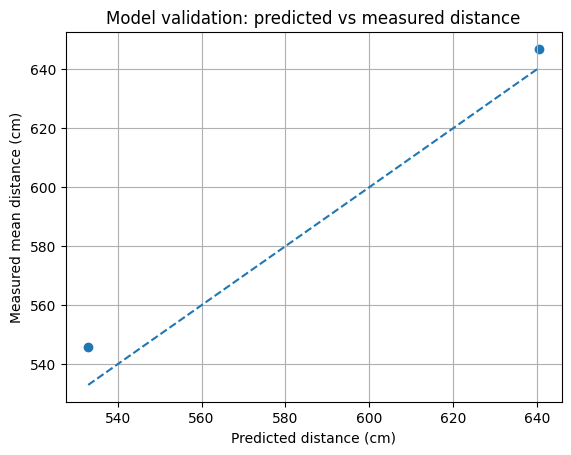

In [40]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(validation_table["Predicted_Distance"], validation_table["mean"])
plt.plot(
    [validation_table["Predicted_Distance"].min(), validation_table["Predicted_Distance"].max()],
    [validation_table["Predicted_Distance"].min(), validation_table["Predicted_Distance"].max()],
    linestyle="--"
)
plt.xlabel("Predicted distance (cm)")
plt.ylabel("Measured mean distance (cm)")
plt.title("Model validation: predicted vs measured distance")
plt.grid(True)
plt.show()


###MODEL VALIDATION USING CONFIRMATION RUNS

To assess the predictive capability of the developed response surface model, two promising configurations identified during the initial screening stage were experimentally tested as confirmation runs. These configurations corresponded to combinations expected to yield high flight distances under low- and high-speed conditions. For each configuration, multiple replicates were performed, and the mean measured distance was compared with the value predicted by the fitted quadratic model.

The comparison between predicted and measured values is shown in predicted vs. measured plot and summarized in Table. **In both cases, the predicted distances were in very good agreement with the experimental means.** The relative errors were small (approximately 2.4% and 1.0%), which is well within the expected experimental variability of this system.

This close agreement indicates that the response surface model successfully captures the dominant trends governing flight distance and can be used reliably for interpolation within the explored design space. Importantly, this external validation provides confidence that the identified optimal regions are not merely mathematical artifacts but correspond to physically meaningful and experimentally reproducible flight behaviors.

###OPTIMIZATION AND FINAL CONFIGURATION RECOMMENDATIONS

After the screening factorial study, a response surface refinement phase was conducted by adding center points for the continuous factors mass (B), launch angle (C), and launch height (D). The selected mid-levels were 5.25 g, 22.5°, and 92.5 cm, respectively. Throw speed was retained as a two-level factor due to the difficulty of achieving a reproducible intermediate level. Separate quadratic response surface models were fitted for low and high speed, allowing the visualization of distance behavior through contour plots and the identification of optimal regions within the experimental range.

The response surfaces indicate that launch height is consistently beneficial for distance, with the highest distances occurring near the maximum tested height (130 cm) in both speed regimes. However, the optimal launch angle depends strongly on speed, consistent with the previously observed conditional behavior (interaction between angle and speed). At low speed, shallow launches are optimal, whereas at high speed the optimum shifts toward an intermediate launch angle that balances lift generation and forward momentum.

---


**Recommended configuration for low speed (distance maximization)**

For low throw speed, the predicted optimum occurs at:

- Launch height: High (130 cm)

- Launch angle: 0°

- Mass: near the upper end of the explored range (~6–7 g)

Therefore, the recommended low-speed configuration is:

A (dart), Mass = Double (7 g), Launch angle = 0°, Launch height = High (130 cm), Speed = Low.

This choice reflects that, at low speed, the airplane benefits more from maximizing forward travel than from vertical lift, and a heavier mass reduces sensitivity and helps maintain a flatter, longer path.

---

**Recommended configuration for high speed (distance maximization)**

For high throw speed, the predicted optimum occurs at:

- Launch height: High (130 cm)

- Launch angle: approximately 22.5–25° (intermediate)

- Mass: low (3.5 g)

Therefore, the recommended high-speed configuration is:

A (dart), Mass = Normal (3.5 g), Launch angle = 22.5° (midpoint), Launch height = High (130 cm), Speed = High.

In this regime, sufficient throw speed allows the airplane to benefit from lift, and an intermediate launch angle produces the best compromise between vertical support and horizontal motion.

---

**Model validation with confirmation runs**

To verify that the predicted optimal settings correspond to real, reproducible performance, confirmation experiments were performed at two promising configurations identified during the earlier stages of the study. The measured mean distances were compared with the response surface predictions. The agreement was very good, with relative errors of approximately 2.36% and 0.99%, indicating that the fitted model provides reliable predictions for flight distance within the tested design space. This validation supports the use of the response surface models for selecting optimal settings and strengthens confidence in the final recommendations.

###CONCLUSIONS

In this study, a structured Design of Experiments (DOE) approach was used to investigate how different design and launch parameters influence the flight performance of a paper airplane. A blocked fractional factorial design allowed the identification of the most important factors and interactions while accounting for day-to-day variability. This screening phase revealed that launch height, launch angle, plane type, and mass significantly affect flight distance, with several effects being conditional on the throw speed.

Following the screening analysis, response surface methodology (RSM) was employed to explore curvature in the system and to locate optimal regions for the continuous factors. The fitted quadratic models showed that launch height consistently improves flight distance, while the optimal launch angle depends strongly on the speed regime. At low speed, shallow launch angles maximize distance, whereas at high speed, an intermediate launch angle provides the best balance between lift and forward momentum. This shift in optimal behavior highlights the importance of interactions and nonlinear effects in the system.

Contour plots were used to visualize these trends and to identify regions of high performance rather than single-point optima. This approach provides a more realistic understanding of the system, acknowledging that small variations in experimental conditions are unavoidable. Based on these surfaces, two recommended configurations were proposed: one optimized for low-speed conditions and one for high-speed conditions.

Finally, confirmation experiments were used to validate the predictive capability of the response surface models. The predicted distances were in very good agreement with the experimentally measured values, with relative errors below 3%. This validation step strengthens confidence in the model and demonstrates that the identified optima correspond to real, reproducible performance.

Overall, this work shows that even a simple system such as a paper airplane exhibits complex, nonlinear behavior that can be effectively analyzed using modern experimental design techniques. The combination of factorial screening, blocking, interaction analysis, response surface modeling, and validation provides a powerful framework for understanding and optimizing physical systems.